In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

plt.style.use("bmh")

# Introduction

## Background

Taylor Swift has been on music industry for more than 10 years; I've started listening to her song since I was in high school - roughly 8 years ago. Time flies, people change, and so do her songs. Her songs shifted from country to pop, and electropop on her Reputation album.

## Research Questions

Considering the various genres, do Taylor Swift's songs also contain various topics?

# Data Preparation

The song lyrics are scraped from [lyrics.com](http://lyrics.com); we use 119 Taylor Swift's song lyrics.

In [54]:
df_song = pd.read_csv("dataset/lyrics/taylor-swift.csv")
df_song = df_song.drop_duplicates(subset='title',keep='first')
df_song = df_song.loc[(df_song['artist'] == 'Taylor Swift')].copy()

In [55]:
def clean_line(series):
    series = series.replace('\n',' ').replace('\r','').replace('\t','')
    return series

cols = ['lyrics','info','credits']
for col in cols:
    df_song[col] = df_song[col].apply(clean_line)

In [56]:
df_song['year'] = df_song['info'].apply(lambda x: x.strip().split(':')[1].split(' ')[1] if ':' in x else None)
df_song['view'] = df_song['info'].apply(lambda x: x.strip().split(':')[1].split(' ')[3].strip().replace('Views','') if ':' in x else x.replace('Views','').replace(' ',''))

In [57]:
from collections import Counter

wc = {}

for idx, row in df_song.iterrows():
    wc[row['title']] = Counter(row['lyrics'].lower().split())

In [58]:
_l = []
for key in wc.keys():
    _l.append(len(wc[key].items()))
    
df_song['unique_word'] = _l

# Analysis

## Initial Exploration

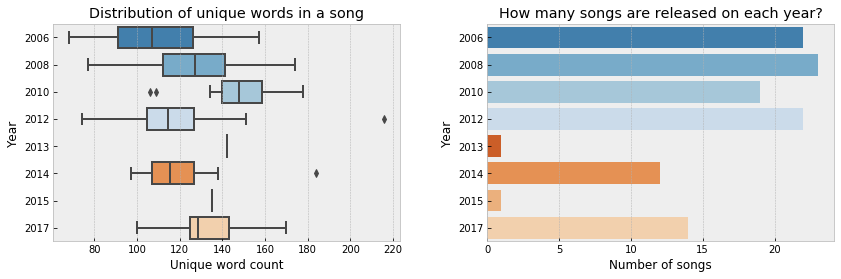

In [60]:
f, ax = plt.subplots(figsize=(14,4), ncols=2)
plt.subplots_adjust(wspace=.25)

sns.boxplot(
    data=df_song.sort_values(by='year'),
    y='year',
    x='unique_word',
    orient='h',
    palette='tab20c',
    ax=ax[0]
)

ax[0].set_title("Distribution of unique words in a song")
ax[0].set_xlabel("Unique word count")
ax[0].set_ylabel("Year")

_df = df_song.groupby('year').agg({'title':pd.Series.nunique}).reset_index()

sns.barplot(
    data=_df,
    y=_df['year'],
    x=_df['title'],
    orient='h',
    palette='tab20c',
    ax=ax[1]
)

ax[1].set_title("How many songs are released on each year?")
ax[1].set_xlabel("Number of songs")
ax[1].set_ylabel("Year")
plt.show();

There is only one song in 2013 and 2015.

In [62]:
df_song.loc[(df_song['year'].isin(['2013','2015']))]

,title,artist,artist_bio,lyrics,info,credits,year,view,unique_word
14,New Romantics,Taylor Swift,Taylor Alison Swift is an American singer-song...,We're all bored We're all so tired of everythi...,Year: 2015 156 Views,Sheet Music Playlist Written by: J...,2015,156,135
15,Sweeter Than Fiction,Taylor Swift,Taylor Alison Swift is an American singer-song...,"Hit the ground, hit the ground, hit the ground...",Year: 2013 104 Views,Sheet Music Playlist Written by: J...,2013,104,142


In [63]:
from wordcloud import WordCloud, STOPWORDS 

def generate_wordcloud(text): # optionally add: stopwords=STOPWORDS and change the arg below
    wordcloud = WordCloud(relative_scaling = 1.0,
                          background_color = 'white',
                          random_state = 101,
                          width = 1200,
                          height = 600,
                          stopwords = {'to', 'of','and','the','but','as'} # set or space-separated string
                          ).generate(text)
    f, ax = plt.subplots(figsize=(12,6))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

Fifteen


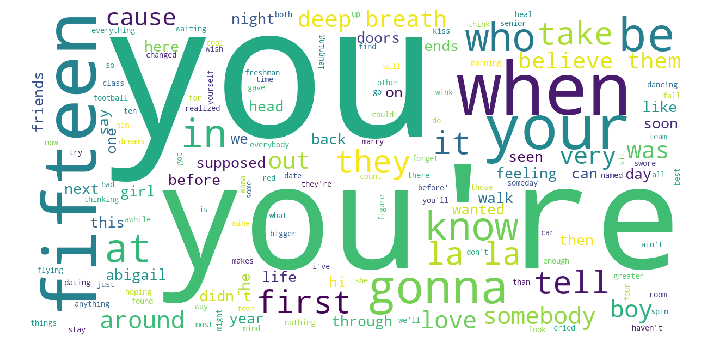

Look What You Made Me Do


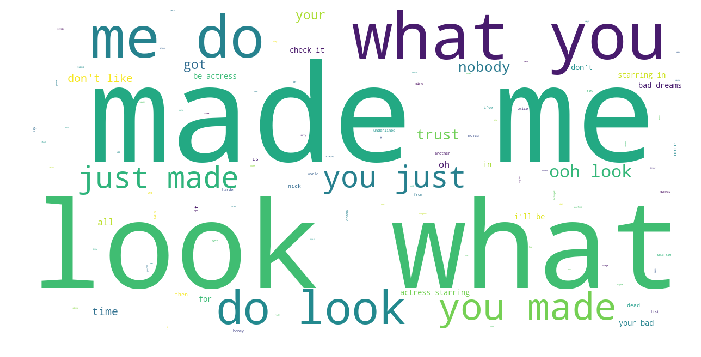

In [72]:
# create sample wordcloud for several songs
print(df_song['title'][0])
generate_wordcloud(df_song['lyrics'][0].lower())

print(df_song['title'][154])
generate_wordcloud(df_song['lyrics'][154].lower())

Nah, we don't want to observe each song's word cloud and compare it one by one.. How about using more sophisticated method?

## Text Preprocessing

In [73]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

from string import punctuation
from collections import Counter
import sys, re

In [74]:
from spacy.lang.en import English

nlp = English()
nlp.Defaults.stop_words.update(stop)

In [75]:
def tokenizer(text):
    return [token.lemma_.lower() for token in nlp(text) if not token.is_stop and not token.is_punct]

In [76]:
df_song['token'] = df_song['lyrics'].str.lower().map(tokenizer)

In [77]:
# store lyrics with cleaned tokens
_lyrics = []

for ix, row in df_song.iterrows():
    _txt = ''
    for word in row['token']:
        if word == ' ':
            continue
        else:
            _txt += word + ' '
    _lyrics.append(_txt)
    
df_song['lyrics_clean'] = _lyrics

In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf_vec = TfidfVectorizer(min_df=10, max_features=10000, tokenizer=tokenizer, ngram_range=(1, 2))
vz = tfidf_vec.fit_transform(df_song['lyrics_clean'])

In [79]:
tfidf = dict(zip(tfidf_vec.get_feature_names(), tfidf_vec.idf_))
tfidf = pd.DataFrame(columns=['idf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['idf']

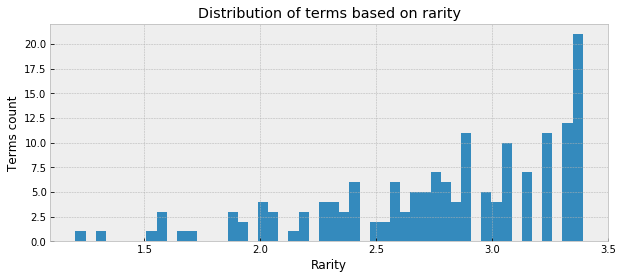

In [80]:
tfidf.idf.hist(bins=50, figsize=(10,4))
plt.xlabel("Rarity")
plt.ylabel("Terms count")
plt.title("Distribution of terms based on rarity")
plt.show()

In [81]:
print("More common terms:")
print(tfidf.sort_values(by=['idf'], ascending=True).head(10).index.values)

print("\n=========================\n")
print("Less common terms:")
print(tfidf.sort_values(by=['idf'], ascending=False).head(10).index.values)

More common terms:
['know' 'like' 'love' 'time' 'think' 'oh' 'come' 'look' 'tell' 'right']


Less common terms:
['high' 'mistake' 'wild' 'grind' 'fake' 'hey' 'let know' 'listen' 'sound'
 'someday']


## Dimensionality Reduction

In [82]:
from sklearn.decomposition import TruncatedSVD


svd = TruncatedSVD(n_components=50, random_state=101)
svd_tfidf = svd.fit_transform(vz)

In [83]:
# get number of unique tokens
_t = []

for ix, row in df_song.iterrows():
    for t in row['token']:
        if t not in _t:
            _t.append(t)
            
print("Number of unique tokens: {:,}".format((len(_t))))

Number of unique tokens: 1,507


In [84]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, verbose=1, random_state=101)
tsne_tfidf = tsne_model.fit_transform(svd_tfidf)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 119 samples in 0.000s...
[t-SNE] Computed neighbors for 119 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 119 / 119
[t-SNE] Mean sigma: 0.451755
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.803425
[t-SNE] Error after 1000 iterations: 0.531938


In [85]:
print("Dimension after SVD: ", svd_tfidf.shape)
print("Dimension after t-SNE: ", tsne_tfidf.shape)

Dimension after SVD:  (119, 50)
Dimension after t-SNE:  (119, 2)


## Clustering

use umap

In [98]:
import umap

reducer = umap.UMAP(n_components=2,
                    n_neighbors=10,
                    random_state=101)
embedding = reducer.fit_transform(tsne_tfidf)

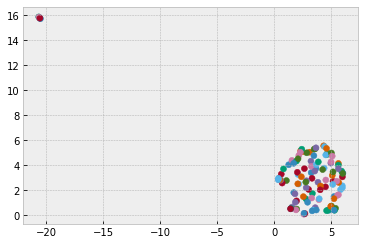

In [102]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in range(0,df_song.year.nunique())]);

In [105]:
# from sklearn.cluster import DBSCAN
import hdbscan

# clf = DBSCAN()
clf = hdbscan.HDBSCAN()
clf.fit(tsne_tfidf)
print('Number of clusters: {}'.format(len(np.unique(clf.labels_))))

df_song['cluster'] = clf.labels_

Number of clusters: 3


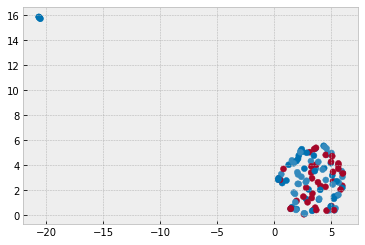

In [108]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in df_song['cluster'].unique()]);

## Topic Modelling

In [114]:
import lda
import logging
logging.getLogger("lda").setLevel(logging.WARNING)

cvectorizer = CountVectorizer(min_df=4, max_features=10000, tokenizer=tokenizer, ngram_range=(1,2))
cvz = cvectorizer.fit_transform(df_song['lyrics_clean'])

n_topics = 3
n_iter = 2000
lda_model = lda.LDA(n_topics=n_topics, n_iter=n_iter, random_state=101)
X_topics = lda_model.fit_transform(cvz)

In [115]:
n_top_words = 10
topic_summaries = []

topic_word = lda_model.topic_word_  # get the topic words
vocab = cvectorizer.get_feature_names()
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: love come know like time oh wish right tell baby
Topic 1: oh oh oh know girl ah place look car think home
Topic 2: know like think look want oh stay eye night shake


In [116]:
tsne_lda = tsne_model.fit_transform(X_topics)


doc_topic = lda_model.doc_topic_
lda_keys = []
for i, txt in enumerate(df_song['lyrics_clean']):
    lda_keys += [doc_topic[i].argmax()]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 119 samples in 0.000s...
[t-SNE] Computed neighbors for 119 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 119 / 119
[t-SNE] Mean sigma: 0.185557
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.281097
[t-SNE] Error after 750 iterations: 0.110982


In [123]:
lda_df = pd.DataFrame(tsne_lda, columns=['x','y'])
lda_df['lyrics'] = df_song['lyrics']
lda_df['year'] = df_song['year']
lda_df['title'] = df_song['title']

lda_df['topic'] = lda_keys
lda_df['topic'] = lda_df['topic'].map(int)

lda_df['token'] = df_song['token']
lda_df['len_docs'] = df_song['token'].map(len)

In [124]:
def prepareLDAData(lda_model, lda_df, cvectorizer):
    data = {
        'vocab': vocab,
        'doc_topic_dists': lda_model.doc_topic_,
        'doc_lengths': list(lda_df['len_docs']),
        'term_frequency':cvectorizer.vocabulary_,
        'topic_term_dists': lda_model.components_
    } 
    return data

In [125]:
import pyLDAvis
pyLDAvis.enable_notebook()

lda_data = prepareLDAData(lda_model=lda_model, lda_df=lda_df, cvectorizer=cvectorizer)
prepared_data = pyLDAvis.prepare(**lda_data)
pyLDAvis.display(prepared_data)

# Results and Discussions

*describe what you find and how it can be improved*

# References



Morris, C. 2017. An Exercise in Language Compression: Are pop lyrics getting more repetitive? Accessed [here](https://pudding.cool/2017/05/song-repetition/).